In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [3]:
# load and randomize

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1.)
movies = pd.read_csv('sentiment/movies.csv').sample(frac=1.)

## Inspecting p(X) of the BOW vectorizers

Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data. 

Of course, this is a very wide distribution, even if we just include unigrams. 

Thus, we will visualize just the most popular features. 

We will see how, given the most popular features of one dataset, the other dataset compares. 

In [4]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B): #TWO DIFFERENT VECTORS
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)   ### frequency of the words 
    tops = np.argsort(sums)[-325:-25]        ### sorts the words based on the frequency
    freqs_A = sums[tops]                     ### ???

    features = np.array(vec_A.get_feature_names())[tops]   ### calling the words

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])     ### comparing which words in vec_A appear in B , does this mean only these words are in both A and B?
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]     ### ???

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [5]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

In [6]:
df[df.dataset == 'A'].head()

,word,dataset,freq
0,used,A,1.475737
1,options,A,1.476206
2,highly,A,1.477350
3,felt,A,1.482937
4,actually,A,1.484884


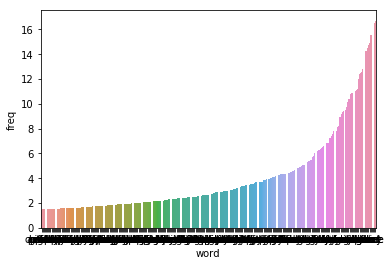

In [7]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A'])

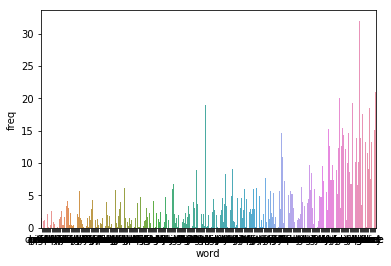

In [8]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B'])

## Generative vs. Discriminative

Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why? 

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


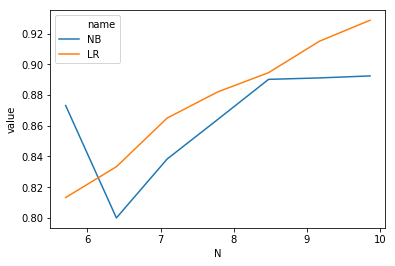

In [9]:
# add vectors here
V = vectorizer.fit_transform(yelps.text)
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression())]

plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200])

## Searching the Grid

Hyperparameter tuning, in its simplest form, can be done via a grid search. 

We can use cross validation to estimate the out-of-sample expected risk. 

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline". 

In [54]:
# Preparing the data and trying several different models with their default hyperparameters.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

## Crosstraining

Test how well your model, when trained on one dataset, performs on the other. 

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"? 

In [55]:
# Perform this on a smaller sample of the data to not break your machine

movies = movies.sample(1000)
yelps = yelps.sample(1000)

yelp_train = vectorizer.fit_transform(yelps.text)
movies_test = vectorizer.transform(movies.text)

### 1. Using SVC

In [56]:
# Set the parameters using the cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
clf_svm = GridSearchCV(SVC(), tuned_parameters, cv=5, return_train_score=True)
model_svm=clf_svm.fit(yelp_train, yelps.positive)

In [57]:
print("Best parameters set found on development set:", model_svm.best_estimator_)
print("Best parameters set found on development set:", model_svm.best_score_)

Best parameters set found on development set: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best parameters set found on development set: 0.875


In [58]:
pred_movies = clf_svm.predict(movies_test)

In [59]:
print(metrics.accuracy_score(movies.positive, pred_movies))

0.679


In [60]:
print(metrics.confusion_matrix(movies.positive, pred_movies))

[[326 152]
 [169 353]]


### 2. Using Logistic Regression

In [61]:
# Set parameters using logistic regresssion
from sklearn.linear_model import LogisticRegression

In [62]:
tuned_parameters_lm = {'C':[1, 10, 100, 1000]}
clf_lr = GridSearchCV(LogisticRegression(), tuned_parameters_lm, cv=5)
model_lr=clf_lr.fit(yelp_train, yelps.positive)

In [63]:
print("Best parameters set found on development set:", model_lr.best_estimator_)
print("Best parameters set found on development set:", model_lr.best_score_)

Best parameters set found on development set: LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best parameters set found on development set: 0.877


In [64]:
pred_movies_lr = clf_lr.predict(movies_test)

In [65]:
print(metrics.accuracy_score(movies.positive, pred_movies_lr))

0.704


In [66]:
print(metrics.confusion_matrix(movies.positive, pred_movies_lr))

[[336 142]
 [154 368]]


#### Out of the two models, it seems logistic regression does a better job, nevertheless in both models there are more false negatives.